In [651]:
#import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import requests
import collections
import re
import json
import glob
import math
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from pandas.io.json import json_normalize
from scipy.spatial.distance import cdist, pdist, squareform
import pandas.tseries.holiday as hol
from sklearn.linear_model import LinearRegression
from pygam import LinearGAM, LogisticGAM, s, f
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

%matplotlib inline

## Trip history 

In [3]:
# Define tripdf: raw trip history data 
# covering 24 months from July 2017-June 2019
tripdf=pd.DataFrame()
for filename in glob.glob("*tripdata.csv"):
    tripdf=tripdf.append(pd.read_csv(filename, parse_dates=["starttime", "stoptime"]))

# Clean tripdf column names
tripdf.columns = tripdf.columns.str.replace(' ', '_')

# Take the columns of interest
trip_simp=tripdf[["start_station_id", "end_station_id", "starttime", "stoptime", 
                  "tripduration", "bikeid"]]
# add counting column for future aggregation 
trip_simp["counting"] = 1

# Map some no-longer existing stations to new stations
fixdict = {1:np.nan, 13:385, 88:381, 155:331, 158:np.nan, 164:np.nan, 168:332, 220:328, 229:np.nan,
           230:np.nan, 231:329, 237:333, 238:334, 240:335, 241:336, 242:337, 243:338, 244:339, 
           245:340, 246:341, 247:342, 248:343, 249:344,250:345, 252:346, 253:347, 254:348, 256:349, 
           257:350, 262:351, 263:353, 264:354, 274:355, 277:356, 278:357, 281:358, 283:327, 284:359, 
           286:330, 293:360, 294:361, 295:362, 299:363, 300:364, 302:365, 306:368, 307:366, 308:np.nan, 
           311:367, 317:np.nan}
trip_simp=trip_simp.replace({"start_station_id":fixdict})
trip_simp=trip_simp.replace({"end_station_id":fixdict})
trip_simp=trip_simp.dropna(subset=["start_station_id"])
trip_simp=trip_simp.dropna(subset=["end_station_id"])

# Add hour timestamp columns
trip_simp['start_hour_stamp'] = trip_simp["starttime"].dt.hour
trip_simp['stop_hour_stamp'] = trip_simp["stoptime"].dt.hour


/Users/kkim14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [5]:
# Check trip_simp
trip_simp.head(3)

,start_station_id,end_station_id,starttime,stoptime,tripduration,bikeid,counting,start_hour_stamp,stop_hour_stamp
0,22.0,60.0,2017-07-01 00:00:21,2017-07-01 00:08:05,463,706,1,0,0
1,22.0,52.0,2017-07-01 00:00:30,2017-07-01 00:12:00,689,565,1,0,0
2,41.0,381.0,2017-07-01 00:01:16,2017-07-01 00:24:14,1377,567,1,0,0


## Station info

In [185]:
# Read in raw and live station data
bike_raw=requests.get("https://member.bluebikes.com/data/stations.json")
bike_data=bike_raw.json()
station=json_normalize(bike_data["stations"])

# Clean column names
station=station[["id", "s", "la", "lo", "d", "ba","da"]]
station["#_of_Docks"] = station.ba + station.da
station=station.drop(["da"], axis=1)
station.columns=["ID", "Station", "Latitude", "Longitude", "Municipality", "Current_Bikes_Midnight","Num_of_Docks"]


In [186]:
# 299 stations 
station.tail(3)

,ID,Station,Latitude,Longitude,Municipality,Current_Bikes_Midnight,Num_of_Docks
296,404,Mass Ave T Station,42.341356,-71.083370,Boston,5,15
297,405,Sydney St at Carson St,42.320394,-71.053554,Boston,12,18
298,406,Somerville City Hall Annex,42.391898,-71.097454,Somerville,3,15


In [187]:
# station ID's not in order
station.head(3)

,ID,Station,Latitude,Longitude,Municipality,Current_Bikes_Midnight,Num_of_Docks
0,36,Copley Square - Dartmouth St at Boylston St,42.349928,-71.077392,Boston,1,32
1,3,Colleges of the Fenway - Fenway at Avenue Loui...,42.340115,-71.100619,Boston,6,15
2,4,Tremont St at E Berkeley St,42.345392,-71.069616,Boston,16,19


In [188]:
# save the dataframe after sorting the ID
station = station.sort_values(by=['ID'])

# remove any stations that are not in operation yet
station=station[station.Num_of_Docks!=0]

station = station.reset_index()
station = station.drop("index", axis=1)


In [189]:
# 291 stations 
station.tail(3)

,ID,Station,Latitude,Longitude,Municipality,Current_Bikes_Midnight,Num_of_Docks
288,404,Mass Ave T Station,42.341356,-71.083370,Boston,5,15
289,405,Sydney St at Carson St,42.320394,-71.053554,Boston,12,18
290,406,Somerville City Hall Annex,42.391898,-71.097454,Somerville,3,15


In [190]:
station_zip=pd.read_csv("station_zip.csv", index_col = 0)
station=station.merge(station_zip[["ID", "zip", "zone"]], how="left", left_on="ID", right_on="ID")

In [191]:
station_needzip=station[station.zip.isna()]
station_needzip

,ID,Station,Latitude,Longitude,Municipality,Current_Bikes_Midnight,Num_of_Docks,zip,zone
10,13,Boston Medical Center - E Concord St at Harris...,42.336399,-71.073067,Boston,5,19,NaN,NaN
87,101,Ball Sq,42.399156,-71.111026,Somerville,5,15,NaN,NaN
271,387,Norman St at Kelvin St,42.405812,-71.067089,Everett,2,15,NaN,NaN
272,388,Main Street at Carter Street,42.404130,-71.061300,Everett,3,13,NaN,NaN
273,389,Everett Square (Broadway at Chelsea St),42.407259,-71.055464,Everett,6,14,NaN,NaN
274,390,Broadway at Lynde St,42.396484,-71.065468,Everett,1,15,NaN,NaN
275,391,Encore,42.393293,-71.072448,Everett,7,15,NaN,NaN
276,392,Glendale Square (Ferry St at Broadway),42.414802,-71.047726,Everett,13,15,NaN,NaN
277,393,Ferry St at Pleasantview Ave,42.409149,-71.045977,Everett,10,13,NaN,NaN
278,394,Broadway at Maple St,42.410347,-71.052605,Everett,1,13,NaN,NaN


In [193]:
API_KEY=""
zipcodelist=[]

for i in range(len(station_needzip)):
    testlat = str(station_needzip.iloc[i].Latitude)
    testlong= str(station_needzip.iloc[i].Longitude)
    rev_geo = requests.get("https://maps.googleapis.com/maps/api/geocode/json?latlng="+testlat+","+testlong+"&key="+API_KEY)
    rev_geo_json = rev_geo.json()
    zipcode=rev_geo_json["results"][0]["formatted_address"].split()[-2][:-1]

    zipcodelist.append(zipcode)
    

station_needzip.zip= zipcodelist

# https://www.arcgis.com/home/webmap/viewer.html?webmap=8f7e2d1a2b264a589cd45c235c9e90a4&extent=-71.2228,42.2538,-71.0089,42.3472
ziptozone={'02108': 0, '02109': 0, '02110':0, '02111':0, '02113':0, '02114':0, '02115':0, '02116':0,
       '02118':0, '02119':1, '02120':1, '02121':1, '02122':1, '02124':1, '02125':1, '02126':1,
       '02127':0, '02128':2, '02129':2, '02130':1, '02131':1, '02134':3, '02135':3, '02138':4,
       '02139':4, '02140':4, '02141':4, '02142':4, '02143':5, '02144':5, '02145':5, '02149':6,
        '02163':3,'02199':0, '02210':0, '02215':0, '02445':3, '02446':3}

station_needzip.zone = station_needzip.zip.map(ziptozone)

for i in station[station.zip.isna()].ID.values:
    newzip=station_needzip[station_needzip.ID==i].zip
    station.loc[station.ID==i,"zip"]= newzip
    newzone=station_needzip[station_needzip.ID==i].zone
    station.loc[station.ID==i,"zone"]= newzone

## tripmonth: aggregation of trip_simp by month
Most of the trips (less than 0.1%) span less than 24 hours. 
We use the start time of each trip. 

In [18]:
shorttrip=trip_simp[trip_simp.tripduration<=86400]
longtrip=trip_simp[trip_simp.tripduration>86400]

len(longtrip),len(shorttrip), len(longtrip)/(len(shorttrip)+len(longtrip))

(2323, 3535924, 0.0006565398062939077)

In [19]:
# Wish I knew a better way but this will do
jul2017=trip_simp.set_index("starttime")["2017-07"].groupby("start_station_id").agg({"counting":"sum"})
aug2017=trip_simp.set_index("starttime")["2017-08"].groupby("start_station_id").agg({"counting":"sum"})
sep2017=trip_simp.set_index("starttime")["2017-09"].groupby("start_station_id").agg({"counting":"sum"})
oct2017=trip_simp.set_index("starttime")["2017-10"].groupby("start_station_id").agg({"counting":"sum"})
nov2017=trip_simp.set_index("starttime")["2017-11"].groupby("start_station_id").agg({"counting":"sum"})
dec2017=trip_simp.set_index("starttime")["2017-12"].groupby("start_station_id").agg({"counting":"sum"})
jan2018=trip_simp.set_index("starttime")["2018-01"].groupby("start_station_id").agg({"counting":"sum"})
feb2018=trip_simp.set_index("starttime")["2018-02"].groupby("start_station_id").agg({"counting":"sum"})
mar2018=trip_simp.set_index("starttime")["2018-03"].groupby("start_station_id").agg({"counting":"sum"})
apr2018=trip_simp.set_index("starttime")["2018-04"].groupby("start_station_id").agg({"counting":"sum"})
may2018=trip_simp.set_index("starttime")["2018-05"].groupby("start_station_id").agg({"counting":"sum"})
jun2018=trip_simp.set_index("starttime")["2018-06"].groupby("start_station_id").agg({"counting":"sum"})
jul2018=trip_simp.set_index("starttime")["2018-07"].groupby("start_station_id").agg({"counting":"sum"})
aug2018=trip_simp.set_index("starttime")["2018-08"].groupby("start_station_id").agg({"counting":"sum"})
sep2018=trip_simp.set_index("starttime")["2018-09"].groupby("start_station_id").agg({"counting":"sum"})
oct2018=trip_simp.set_index("starttime")["2018-10"].groupby("start_station_id").agg({"counting":"sum"})
nov2018=trip_simp.set_index("starttime")["2018-11"].groupby("start_station_id").agg({"counting":"sum"})
dec2018=trip_simp.set_index("starttime")["2018-12"].groupby("start_station_id").agg({"counting":"sum"})
jan2019=trip_simp.set_index("starttime")["2019-01"].groupby("start_station_id").agg({"counting":"sum"})
feb2019=trip_simp.set_index("starttime")["2019-02"].groupby("start_station_id").agg({"counting":"sum"})
mar2019=trip_simp.set_index("starttime")["2019-03"].groupby("start_station_id").agg({"counting":"sum"})
apr2019=trip_simp.set_index("starttime")["2019-04"].groupby("start_station_id").agg({"counting":"sum"})
may2019=trip_simp.set_index("starttime")["2019-05"].groupby("start_station_id").agg({"counting":"sum"})
jun2019=trip_simp.set_index("starttime")["2019-06"].groupby("start_station_id").agg({"counting":"sum"})


# Define tripmonth
tripmonth=pd.concat([jul2017, aug2017, sep2017, oct2017, nov2017, dec2017, 
           jan2018, feb2018, mar2018, apr2018, may2018, jun2018, 
           jul2018, aug2018, sep2018, oct2018, nov2018, dec2018, 
           jan2019, feb2019, mar2019, apr2019, may2019, jun2019], axis=1)

tripmonth.columns = ["Jul17", "Aug17", "Sep17", "Oct17", "Nov17", "Dec17", 
           "Jan18", "Feb18", "Mar18", "Apr18", "May18", "Jun18", 
           "Jul18", "Aug18", "Sep18", "Oct18", "Nov18", "Dec18", 
           "Jan19", "Feb19", "Mar19", "Apr19", "May19", "Jun19"]

In [29]:
# Some stations did not operate during winter
tripmonth.head(3)

,Jul17,Aug17,Sep17,Oct17,Nov17,Dec17,Jan18,Feb18,Mar18,Apr18,...,Sep18,Oct18,Nov18,Dec18,Jan19,Feb19,Mar19,Apr19,May19,Jun19
start_station_id,,,,,,,,,,,,,,,,,,,,,
3.0,631.0,710.0,575.0,547.0,319.0,169.0,169.0,294.0,289.0,304.0,...,830.0,669.0,427.0,259.0,193.0,294.0,333.0,698.0,730.0,917.0
4.0,1208.0,1330.0,1176.0,1068.0,734.0,477.0,311.0,402.0,436.0,613.0,...,1295.0,1064.0,604.0,441.0,369.0,375.0,454.0,861.0,1212.0,1513.0
5.0,1059.0,1170.0,1079.0,1059.0,684.0,134.0,NaN,NaN,NaN,384.0,...,1765.0,1496.0,819.0,412.0,190.0,NaN,NaN,593.0,1056.0,1249.0


In [30]:
# Some stations recently opened
tripmonth.tail(3)

,Jul17,Aug17,Sep17,Oct17,Nov17,Dec17,Jan18,Feb18,Mar18,Apr18,...,Sep18,Oct18,Nov18,Dec18,Jan19,Feb19,Mar19,Apr19,May19,Jun19
start_station_id,,,,,,,,,,,,,,,,,,,,,
395.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0
396.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0
397.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0


Counting total number of trips per station is biased since some stations has been operating and started operating for shorter. To compensate for this, we count for how many months each station has been open. 


In [39]:
tripmonth["Op_Months"] = tripmonth.iloc[:, :].notna().sum(axis=1)
tripmonth["Trips_Per_Month"]=tripmonth.iloc[:, :-1].sum(axis=1)/tripmonth.Op_Months

In [55]:
tripmonth.head()

,Jul17,Aug17,Sep17,Oct17,Nov17,Dec17,Jan18,Feb18,Mar18,Apr18,...,Nov18,Dec18,Jan19,Feb19,Mar19,Apr19,May19,Jun19,Op_Months,Trips_Per_Month
start_station_id,,,,,,,,,,,,,,,,,,,,,
3.0,631.0,710.0,575.0,547.0,319.0,169.0,169.0,294.0,289.0,304.0,...,427.0,259.0,193.0,294.0,333.0,698.0,730.0,917.0,24,517.000000
4.0,1208.0,1330.0,1176.0,1068.0,734.0,477.0,311.0,402.0,436.0,613.0,...,604.0,441.0,369.0,375.0,454.0,861.0,1212.0,1513.0,24,877.166667
5.0,1059.0,1170.0,1079.0,1059.0,684.0,134.0,NaN,NaN,NaN,384.0,...,819.0,412.0,190.0,NaN,NaN,593.0,1056.0,1249.0,19,916.631579
6.0,1670.0,1833.0,1432.0,1468.0,989.0,574.0,378.0,636.0,652.0,967.0,...,1013.0,931.0,848.0,982.0,1290.0,1705.0,2050.0,2207.0,24,1403.083333
7.0,578.0,667.0,475.0,396.0,281.0,185.0,94.0,185.0,168.0,233.0,...,270.0,209.0,233.0,234.0,293.0,372.0,530.0,708.0,24,397.208333


## MBTA subway
No Silver line or Manttapan trolley

In [404]:
MBTAstops=pd.read_csv("MBTA_GTFS/stops.txt", sep=",")
MBTA_subway=MBTAstops[MBTAstops.location_type==1]
MBTA_subway=MBTA_subway[~MBTA_subway.stop_name.isin(["Eastern Avenue", "Box District", "Bellingham Square", "Chelsea", "World Trade Center", "Courthouse", "Silver Line Way", 'Butler','Capen Street','Cedar Grove','Central Avenue','Mattapan','Milton','Valley Road','Wollaston'])]
MBTA_subway=MBTA_subway[["stop_name", "stop_lat", "stop_lon"]]

In [405]:
redline= set(["Alewife", "Davis", "Porter", "Harvard", "Central", "Kendall/MIT", "Charles/MGH", "Park Street", "Downtown Crossing", "South Station", "Broadway", "Andrew", "JFK/UMass", "North Quincy", "Quincy Center", "Quincy Adams", "Braintree", "Savin Hill", "Fields Corner", "Shawmut","Ashmont"])
orangeline= set(["Oak Grove", "Malden Center", "Wellington", "Assembly", "Sullivan Square", "Community College", "North Station", "Haymarket", "State", "Downtown Crossing", "Chinatown", "Tufts Medical Center", "Back Bay", "Massachusetts Avenue", "Ruggles", "Roxbury Crossing", "Jackson Square", "Stony Brook", "Green Street", "Forest Hills"])
blueline=set(["Wonderland", "Revere Beach", "Beachmont", "Suffolk Downs", "Orient Heights", "Wood Island", "Airport", "Maverick", "Aquarium", "State", "Government Center", "Bowdoin"])
greenE=set(["Lechmere", "Science Park", "North Station", "Haymarket", "Government Center", "Park Street", "Boylston", "Arlington", "Copley", "Prudential", "Symphony", "Northeastern University", "Museum of Fine Arts", "Longwood Medical Area", "Brigham Circle", "Fenwood Road", "Mission Park", "Riverway", "Back of the Hill", "Heath Street"])
greenD=set(["Government Center", "Park Street", "Boylston", "Arlington", "Copley", "Hynes Convention Center", "Kenmore", "Fenway", "Longwood", "Brookline Village", "Brookline Hills", "Beaconsfield", "Reservoir", "Chestnut Hill", "Newton Centre", "Newton Highlands", "Eliot", "Waban", "Woodland", "Riverside"])
greenC=set(["North Station", "Haymarket", "Government Center", "Park Street", "Boylston", "Arlington", "Copley", "Hynes Convention Center", "Kenmore", "Saint Marys Street", "Hawes Street", "Kent Street", "Saint Paul Street", "Coolidge Corner", "Summit Avenue", "Brandon Hall", "Fairbanks Street", "Washington Square", "Tappan Street", "Dean Road", "Englewood Avenue", "Cleveland Circle"])
greenB=set(["Park Street", "Boylston", "Arlington", "Copley", "Hynes Convention Center", "Kenmore", "Blandford Street", "Boston University East", "Boston University West", "Boston University Central", "Saint Paul Street", "Pleasant Street", "Babcock Street", "Packards Corner", "Harvard Avenue", "Griggs Street", "Allston Street", "Warren Street", "Washington Street", "Sutherland Road", "Chiswick Road", "Chestnut Hill Avenue", "South Street", "Boston College"])

In [411]:
MBTA_subway=MBTA_subway.reset_index().drop("index", axis=1)

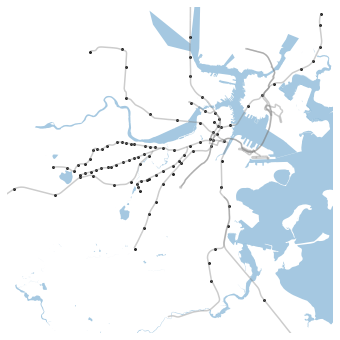

In [414]:
crs={'init':'epsg:4326'}

geometry=[Point(xy) for xy in zip(MBTA_subway.stop_lon, MBTA_subway.stop_lat)]
MBTA_subway_geo=gpd.GeoDataFrame(MBTA_subway, crs=crs, geometry = geometry).to_crs(epsg=26986)
fig, ax=plt.subplots(figsize=(6, 6))
ax.set_xlim([225000, 242500])
ax.set_ylim([890000, 907500])

metroarc= gpd.read_file("mbta_rapid_transit/MBTA_ARC.shp")
metroarc.plot(ax=ax, alpha=0.4, color="grey")
waterpoly = gpd.read_file("Hydrography_Polygon_(1)/Hydrography_Polygon.shp").to_crs(epsg=26986)
waterpoly.plot(ax=ax, alpha=0.4)

MBTA_subway_geo.plot(ax=ax, color="black", alpha=0.8, markersize=4)
_=plt.axis('off')

## time_df: aggregation of trip_simp by hour

In [668]:
### !!Run this code after!! cleaning the dataframe "data" (See below)
trip_right_stations=trip_simp[(trip_simp.start_station_id.isin(data.ID.values)) & trip_simp.end_station_id.isin(data.ID.values)]
starthours=pd.pivot_table(trip_right_stations, values="counting", index="start_station_id", columns="start_hour_stamp", aggfunc=np.sum)
endhours=pd.pivot_table(trip_right_stations, values="counting", index="end_station_id", columns="stop_hour_stamp", aggfunc=np.sum)

In [669]:
time_df=starthours.subtract(endhours).fillna(0).reset_index()
time_df.rename(columns={"start_station_id":"ID"}, inplace=True)
time_df.head()

start_hour_stamp,ID,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,3.0,-10.0,-26.0,-3.0,-15.0,4.0,6.0,-182.0,-112.0,-887.0,...,107.0,292.0,650.0,802.0,39.0,-8.0,-82.0,-39.0,2.0,-19.0
1,4.0,100.0,97.0,50.0,-6.0,5.0,293.0,559.0,1715.0,1535.0,...,-171.0,-256.0,-564.0,-2028.0,-1069.0,-522.0,-317.0,-147.0,25.0,3.0
2,5.0,-19.0,-57.0,-15.0,-10.0,-8.0,-2.0,85.0,376.0,46.0,...,-19.0,26.0,-317.0,-317.0,-85.0,103.0,71.0,108.0,18.0,-13.0
3,6.0,-28.0,15.0,37.0,-1.0,-32.0,339.0,301.0,592.0,682.0,...,-158.0,-212.0,-209.0,-35.0,-29.0,-121.0,-291.0,-331.0,-137.0,-44.0
4,7.0,30.0,17.0,-3.0,-4.0,-1.0,-40.0,-335.0,-1114.0,-2046.0,...,137.0,392.0,1326.0,1698.0,350.0,121.0,81.0,114.0,114.0,48.0


In [311]:
time_df_std=time_df.iloc[:, 1:].values.flatten().std()
time_df_med=np.median(time_df.iloc[:, 1:].values.flatten())
time_df_std, time_df_med

(724.4570988321184, 0.0)

In [312]:
time_df.iloc[:, 1:] = (time_df.iloc[:, 1:]-time_df_med)/time_df_std

In [313]:
time_df.head(3)

start_hour_stamp,ID,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,3.0,-0.013803,-0.035889,-0.004141,-0.020705,0.005521,0.008282,-0.251223,-0.154599,-1.224365,...,0.147697,0.403060,0.897224,1.107036,0.053833,-0.011043,-0.113188,-0.053833,0.002761,-0.026227
1,4.0,0.138034,0.133893,0.069017,-0.008282,0.006902,0.404441,0.771612,2.367290,2.118828,...,-0.236039,-0.353368,-0.778514,-2.799338,-1.475588,-0.720540,-0.437569,-0.202911,0.034509,0.004141
2,5.0,-0.026227,-0.078680,-0.020705,-0.013803,-0.011043,-0.002761,0.117329,0.519009,0.063496,...,-0.026227,0.035889,-0.437569,-0.437569,-0.117329,0.142175,0.098004,0.149077,0.024846,-0.017944


array([-1.38904015,  1.64902794])

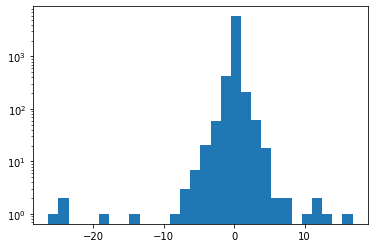

In [297]:
_=plt.hist(time_df.iloc[:, 1:].values.flatten(), bins=30)
plt.yscale("log")
np.percentile(time_df.iloc[:, 1:].values.flatten(), [2.5, 97.5])

## data: the main dataframe that will be used for ML

In [712]:
# Left-merge station (which is up to date) and tripmonth[["Op_Months", "Trips_Per_Month"]]
# to see which stations we will keep for analysis
data = pd.merge(station, tripmonth.reset_index()[["start_station_id", "Op_Months","Trips_Per_Month"]], 
                how="left", left_on="ID", right_on="start_station_id")

We note that some stations that show in "station" started operating in July 2019. Since we only have trip history up to June 2019, we will ignore these new stations as well. 

In [664]:
data.tail()

,ID,Station,Latitude,Longitude,Municipality,Current_Bikes_Midnight,Num_of_Docks,zip,zone,start_station_id,Op_Months,Trips_Per_Month
286,402,Washington St at Griggs Rd,42.338334,-71.130509,Brookline,8,13,2446,3.0,NaN,NaN,NaN
287,403,Marion St at Harvard St,42.339781,-71.121334,Brookline,9,15,2446,3.0,NaN,NaN,NaN
288,404,Mass Ave T Station,42.341356,-71.083370,Boston,5,15,02118,0.0,NaN,NaN,NaN
289,405,Sydney St at Carson St,42.320394,-71.053554,Boston,12,18,02125,1.0,NaN,NaN,NaN
290,406,Somerville City Hall Annex,42.391898,-71.097454,Somerville,3,15,02145,5.0,NaN,NaN,NaN


In [713]:
# Ignore such stations
data=data[data.start_station_id.notna()]

In [715]:
# Most (in fact all) Everett stations are newly open in June 2019!
# Total 277 stations
data=data.reset_index().drop("index", axis=1)
data.tail()

,ID,Station,Latitude,Longitude,Municipality,Current_Bikes_Midnight,Num_of_Docks,zip,zone,start_station_id,Op_Months,Trips_Per_Month
272,393,Ferry St at Pleasantview Ave,42.409149,-71.045977,Everett,10,13,02149,6.0,393.0,1.0,14.0
273,394,Broadway at Maple St,42.410347,-71.052605,Everett,1,13,02149,6.0,394.0,1.0,13.0
274,395,Chelsea St at Vine St,42.403281,-71.047626,Everett,9,15,02149,6.0,395.0,1.0,13.0
275,396,Main St at Beacon St,42.410727,-71.062668,Everett,6,15,02149,6.0,396.0,1.0,38.0
276,397,Broadway at Beacham St,42.398361,-71.063738,Everett,9,13,02149,6.0,397.0,1.0,97.0


In [716]:
# Popular stations. Sort this data by Trips_Per_Month
# Top 5 (in fact, top 35) stations are all in zone 4 (Cambridge) or zone (Downtown Boston)
data.sort_values("Trips_Per_Month", ascending=False).head()

,ID,Station,Latitude,Longitude,Municipality,Current_Bikes_Midnight,Num_of_Docks,zip,zone,start_station_id,Op_Months,Trips_Per_Month
54,67,MIT at Mass Ave / Amherst St,42.358100,-71.093198,Cambridge,0,24,2139,4.0,67.0,24.0,4381.166667
67,80,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,Cambridge,0,16,2142,4.0,80.0,24.0,3208.458333
55,68,Central Square at Mass Ave / Essex St,42.365070,-71.103100,Cambridge,4,16,2139,4.0,68.0,24.0,3044.458333
17,22,South Station - 700 Atlantic Ave,42.352175,-71.055547,Boston,19,43,2110,0.0,22.0,24.0,2997.291667
41,53,Beacon St at Massachusetts Ave,42.350827,-71.089811,Boston,9,16,2115,0.0,53.0,16.0,2877.562500


## Collection of station plots
### 1. by zone

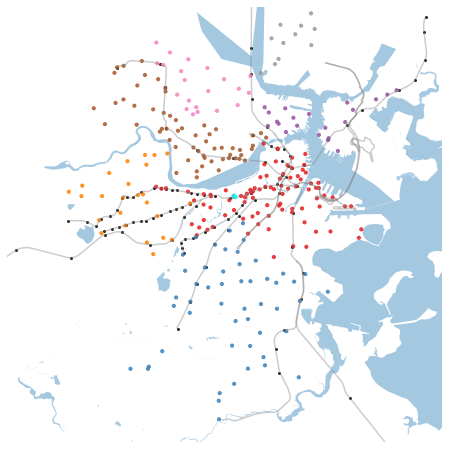

In [440]:
# WITH DISTRICT
crs={'init':'epsg:4326'}

geometry=[Point(xy) for xy in zip(data.Longitude, data.Latitude)]
data_geo=gpd.GeoDataFrame(data, crs=crs, geometry = geometry).to_crs(epsg=26986)
fig, ax=plt.subplots(figsize=(8, 8))
ax.set_xlim([225000, 242500])
ax.set_ylim([890000, 907500])

metroarc= gpd.read_file("mbta_rapid_transit/MBTA_ARC.shp")
metroarc.plot(ax=ax, alpha=0.4, color="grey")
waterpoly = gpd.read_file("Hydrography_Polygon_(1)/Hydrography_Polygon.shp").to_crs(epsg=26986)
waterpoly.plot(ax=ax, alpha=0.4)

MBTA_subway_geo.plot(ax=ax, color="black", alpha=0.8, markersize=4)

_=data_geo.plot(column="zone", cmap="Set1", ax=ax,  alpha=0.8, markersize=10)
_=plt.axis('off')

# bikecenter
# !!! Run this last line after defining bikecenter !!! 
data_geo[data_geo.ID==52].plot(ax=ax,color="cyan", marker="*")


### 2.  by hour

/Users/kkim14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


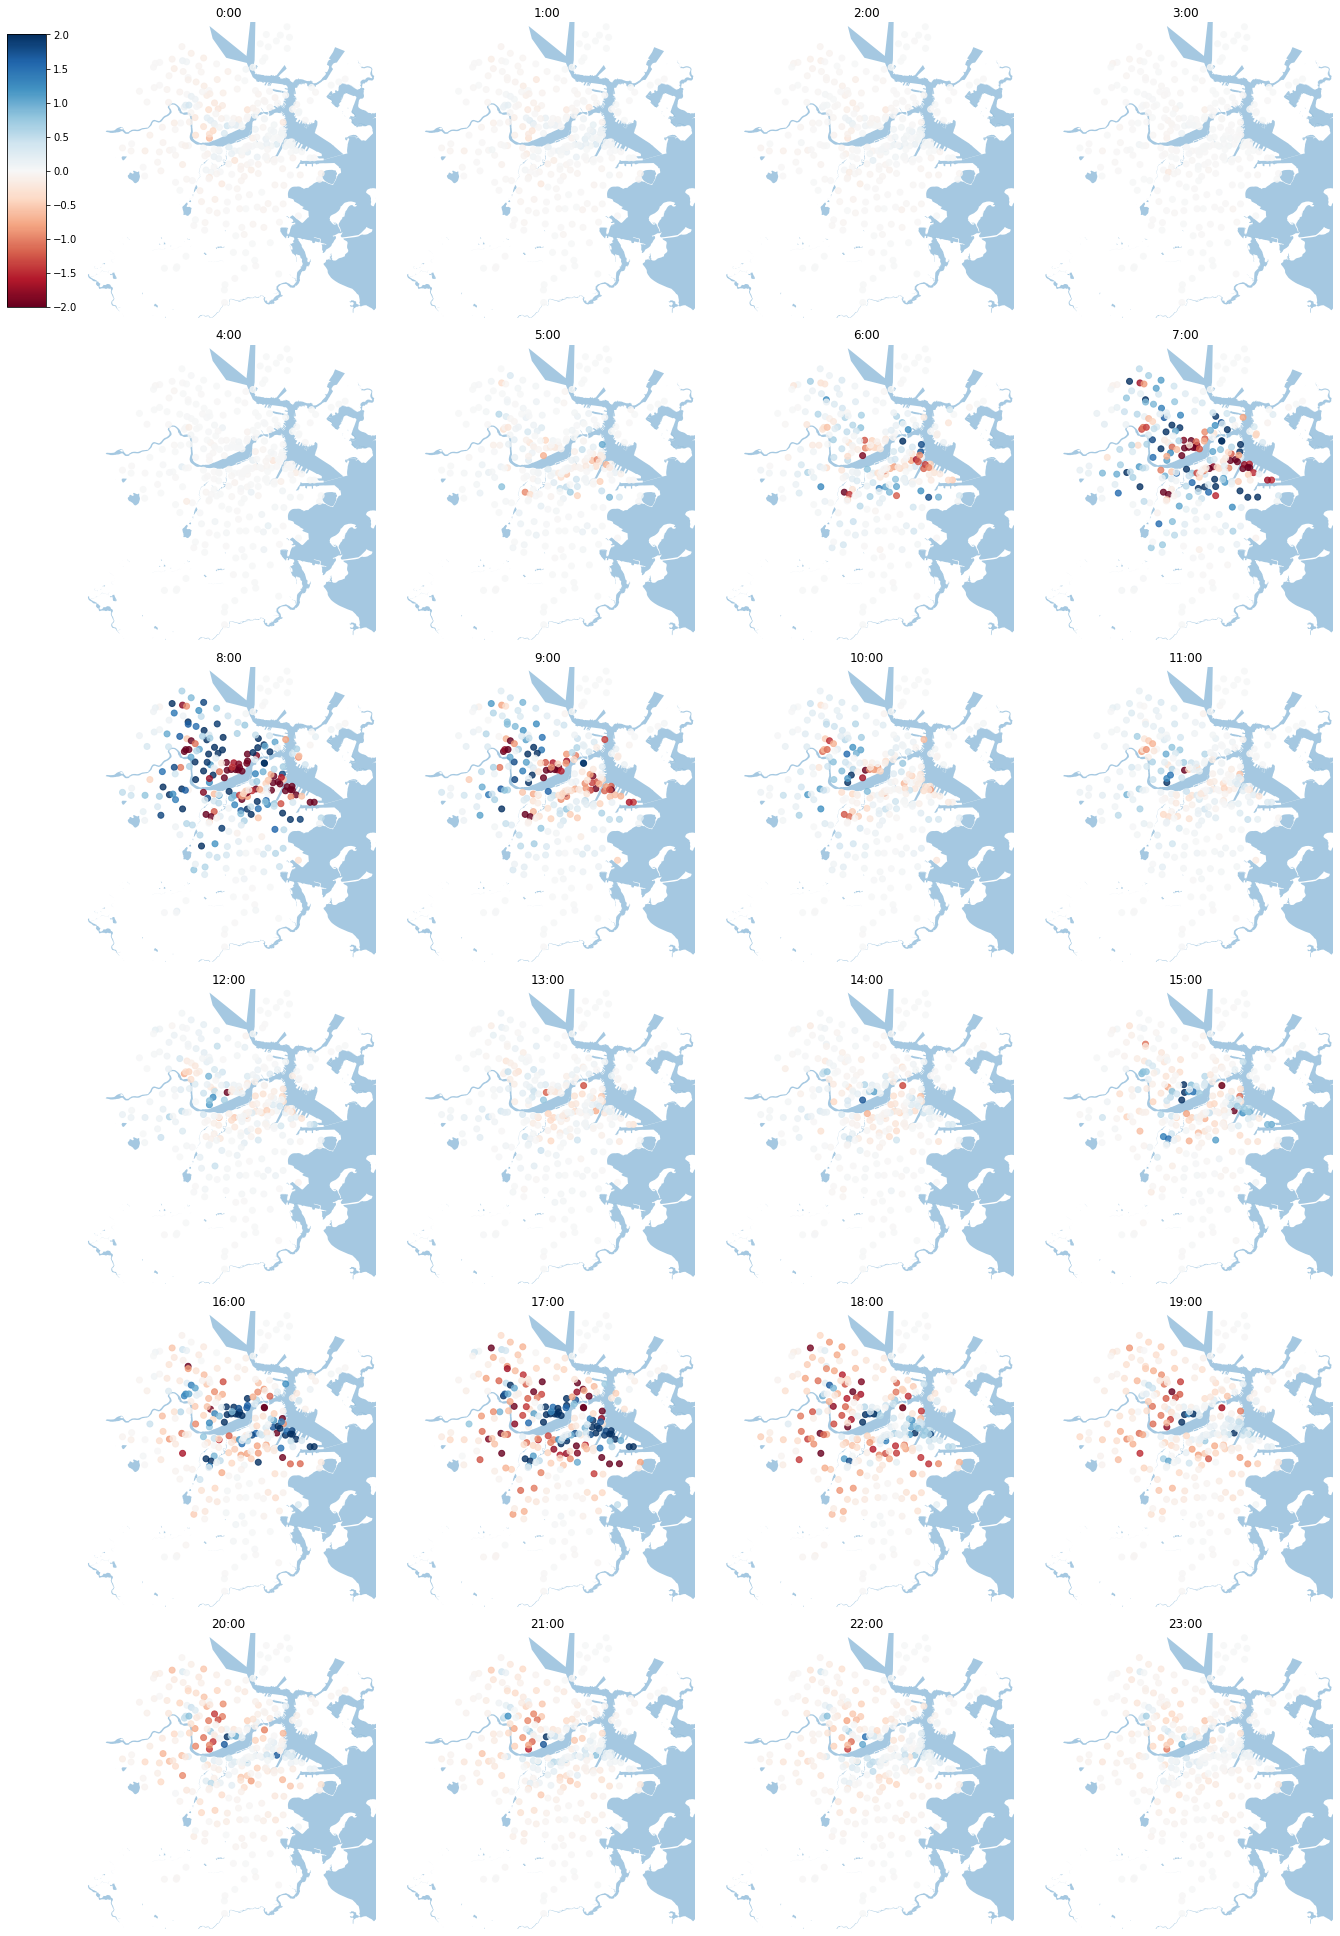

In [329]:
crs={'init':'epsg:4326'}

geometry=[Point(xy) for xy in zip(data.Longitude, data.Latitude)]
data_hour_geo=gpd.GeoDataFrame(data.merge(time_df, how="left", left_on="ID", right_on="ID"), crs=crs, geometry = geometry).to_crs(epsg=26986)

fig= plt.subplots(figsize=(18,27))
for i in range(24):
    ax = plt.subplot(6,4,i+1)
    ax.set_xlim([225000, 242500])
    ax.set_ylim([890000, 907500])
    waterpoly = gpd.read_file("Hydrography_Polygon_(1)/Hydrography_Polygon.shp").to_crs(epsg=26986)
    waterpoly.plot(ax=ax, alpha=0.4)

    data_hour_geo.plot(column =i, cmap="RdBu",vmin=-2, vmax=2, ax=ax, alpha=0.8)
    plt.title(str(i)+":00")
    plt.axis('off')


fig = ax.get_figure()
cax = fig.add_axes([-0.04, 0.84, 0.03, 0.14]) #left bottom width height
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=plt.Normalize(vmin=-2, vmax=2))
sm._A = []
fig.colorbar(sm, cax=cax)
    
plt.tight_layout()

/Users/kkim14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


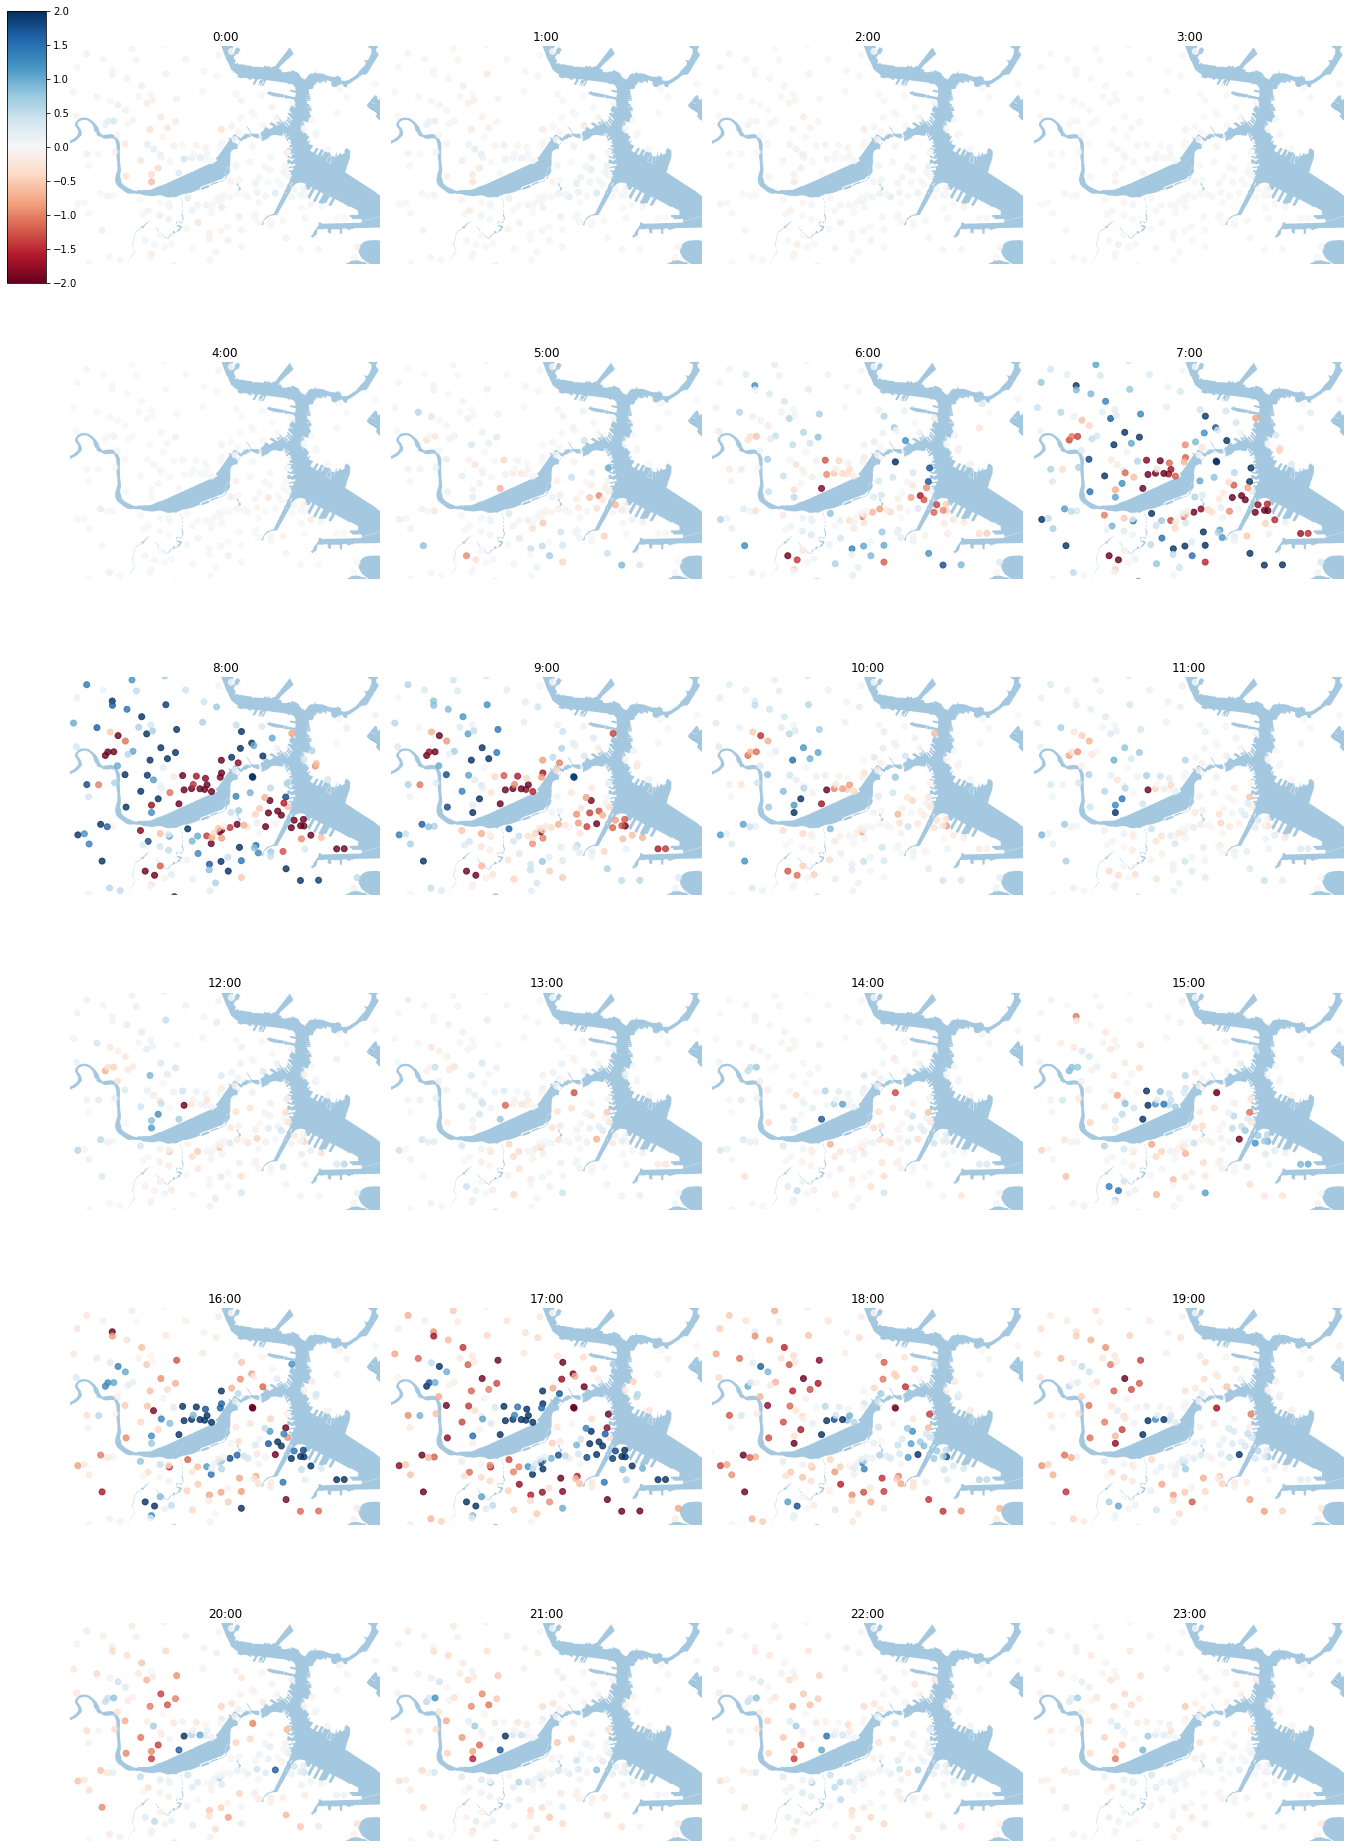

In [340]:
# Zoom-in the center
crs={'init':'epsg:4326'}

geometry=[Point(xy) for xy in zip(data.Longitude, data.Latitude)]
data_hour_geo=gpd.GeoDataFrame(data.merge(time_df, how="left", left_on="ID", right_on="ID"), crs=crs, geometry = geometry).to_crs(epsg=26986)

fig= plt.subplots(figsize=(18,27))
for i in range(24):
    ax = plt.subplot(6,4,i+1)
    ax.set_xlim([230000, 240000])
    ax.set_ylim([898000, 905000])
    waterpoly = gpd.read_file("Hydrography_Polygon_(1)/Hydrography_Polygon.shp").to_crs(epsg=26986)
    waterpoly.plot(ax=ax, alpha=0.4)

    data_hour_geo.plot(column =i, cmap="RdBu",vmin=-2, vmax=2, ax=ax, alpha=0.8)
    plt.title(str(i)+":00")
    plt.axis('off')


fig = ax.get_figure()
cax = fig.add_axes([-0.04, 0.84, 0.03, 0.14]) #left bottom width height
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=plt.Normalize(vmin=-2, vmax=2))
sm._A = []
fig.colorbar(sm, cax=cax)
    
plt.tight_layout()

### 3. by KMean cluster

In [468]:
time_df.head(3)

start_hour_stamp,ID,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,3.0,-0.013803,-0.035889,-0.004141,-0.020705,0.005521,0.008282,-0.251223,-0.154599,-1.224365,...,0.147697,0.403060,0.897224,1.107036,0.053833,-0.011043,-0.113188,-0.053833,0.002761,-0.026227
1,4.0,0.138034,0.133893,0.069017,-0.008282,0.006902,0.404441,0.771612,2.367290,2.118828,...,-0.236039,-0.353368,-0.778514,-2.799338,-1.475588,-0.720540,-0.437569,-0.202911,0.034509,0.004141
2,5.0,-0.026227,-0.078680,-0.020705,-0.013803,-0.011043,-0.002761,0.117329,0.519009,0.063496,...,-0.026227,0.035889,-0.437569,-0.437569,-0.117329,0.142175,0.098004,0.149077,0.024846,-0.017944


In [717]:
kmeans= KMeans(n_clusters=2)
_=kmeans.fit_transform(time_df.iloc[:,1:])
data["kmean_labels_2"]=kmeans.labels_

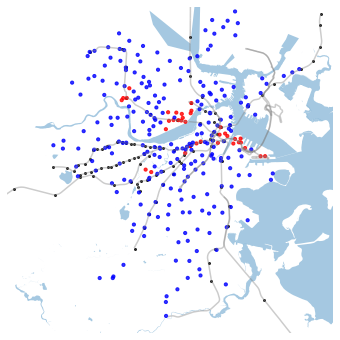

In [672]:
# WITH DISTRICT
crs={'init':'epsg:4326'}

geometry=[Point(xy) for xy in zip(data.Longitude, data.Latitude)]
data_geo=gpd.GeoDataFrame(data, crs=crs, geometry = geometry).to_crs(epsg=26986)
fig, ax=plt.subplots(figsize=(6, 6))
ax.set_xlim([225000, 242500])
ax.set_ylim([890000, 907500])

metroarc= gpd.read_file("mbta_rapid_transit/MBTA_ARC.shp")
metroarc.plot(ax=ax, alpha=0.4, color="grey")
waterpoly = gpd.read_file("Hydrography_Polygon_(1)/Hydrography_Polygon.shp").to_crs(epsg=26986)
waterpoly.plot(ax=ax, alpha=0.4)

MBTA_subway_geo.plot(ax=ax, color="black", alpha=0.8, markersize=4)
_=data_geo.plot(column="kmean_labels_2", cmap="bwr", ax=ax,  alpha=0.8, markersize=10)
_=plt.axis('off')

# Center-most
#station_zip_geo[station_zip_geo.ID==53].plot(ax=ax,color="cyan", marker="*")


In [422]:
data.kmean_labels_2.value_counts()

1    241
0     36
Name: kmean_labels_2, dtype: int64

## Define variables
* nodes_bikes
* nodes_subway
* bikecenter
* dist_from_bikes_to_bikes
* mindist_from_bikes_to_subway
* dist_bikecenter
* dist_bikemit
* num_bikenodes_in_01
* biketripcount_in_01
* biketripcount_in_005
* mindist_to_pop



In [718]:
nodes_bikes=np.array(list(zip(data.Longitude, data.Latitude)))
nodes_subway=np.array(list(zip(MBTA_subway.stop_lon, MBTA_subway.stop_lat)))

In [719]:
# The most center point : the average distance to all other nodes is the smallest
avg_dists_nodes = squareform(pdist(nodes_bikes)).mean(axis=1)

bikecenter= nodes_bikes[avg_dists_nodes.argmin()]
data.iloc[[nodes_bikes.tolist().index([bikecenter[0], bikecenter[1]])]]

,ID,Station,Latitude,Longitude,Municipality,Current_Bikes_Midnight,Num_of_Docks,zip,zone,start_station_id,Op_Months,Trips_Per_Month,kmean_labels_2
40,52,Newbury St at Hereford St,42.348717,-71.085954,Boston,3,22,2115,0.0,52.0,16.0,1880.125,1


In [720]:
# distance from each bike station to bikecenter
dist_bikecenter= cdist(nodes_bikes, [nodes_bikes[52]])
data["dist_bikecenter"] = dist_bikecenter

In [721]:
# Shortest distance from each bike station to its nearest subwasy station
mindist_from_bikes_to_subway=np.min(cdist(nodes_bikes, nodes_subway)*1000, axis=1)
data["mindist_bikes_sub"]=mindist_from_bikes_to_subway

In [722]:
# Matrix which contains the pairwise distance between bike stations
dist_from_bikes_to_bikes=cdist(nodes_bikes, nodes_bikes)
num_bikenodes_in_01=[]
for i in range(len(nodes_bikes)):
    num_bikenodes_in_01.append(len(dist_from_bikes_to_bikes[i][dist_from_bikes_to_bikes[i]< 0.01]))
data["num_bikenodes_in_01"]=num_bikenodes_in_01

In [723]:
# Number of bike stations within radius 0.01 
biketripcount_in_01=[]
for i in range(len(nodes_bikes)):
    biketripcount_in_01.append(data.Trips_Per_Month[dist_from_bikes_to_bikes[i]<0.01].sum())
                               #+station_df.total_trip_count_y[stationdistance[i]<0.01].sum())
data["biketripcount_in_01"]=biketripcount_in_01

In [724]:
# Number of bike stations within radius 0.005
biketripcount_in_005=[]
for i in range(len(nodes_bikes)):
    biketripcount_in_005.append(data.Trips_Per_Month[dist_from_bikes_to_bikes[i]<0.005].sum())
                               #+station_df.total_trip_count_y[stationdistance[i]<0.005].sum())
data["biketripcount_in_005"]=biketripcount_in_005

In [725]:
data=pd.concat([data, pd.get_dummies(data.zone, drop_first=True)], axis=1)
data.head(3)

,ID,Station,Latitude,Longitude,Municipality,Current_Bikes_Midnight,Num_of_Docks,zip,zone,start_station_id,...,mindist_bikes_sub,num_bikenodes_in_01,biketripcount_in_01,biketripcount_in_005,1.0,2.0,3.0,4.0,5.0,6.0
0,3,Colleges of the Fenway - Fenway at Avenue Loui...,42.340115,-71.100619,Boston,6,15,2115,0.0,3.0,...,4.193608,14,10552.246825,1638.375000,0,0,0,0,0,0
1,4,Tremont St at E Berkeley St,42.345392,-71.069616,Boston,16,19,2116,0.0,4.0,...,6.417015,20,17274.082937,1759.833333,0,0,0,0,0,0
2,5,Northeastern University - North Parking Lot,42.341814,-71.090179,Boston,2,13,2115,0.0,5.0,...,1.970203,11,14331.027412,2453.006579,0,0,0,0,0,0


In [727]:
# Minimal distance to stations labeled as 0 by KMeans
pop_stations = data[data.kmean_labels_2 ==0]
pop_stations.head()

,ID,Station,Latitude,Longitude,Municipality,Current_Bikes_Midnight,Num_of_Docks,zip,zone,start_station_id,...,mindist_bikes_sub,num_bikenodes_in_01,biketripcount_in_01,biketripcount_in_005,1.0,2.0,3.0,4.0,5.0,6.0
4,7,Fan Pier,42.353391,-71.044571,Boston,0,14,2210,0.0,7.0,...,9.540003,13,9659.644841,2915.422619,0,0,0,0,0,0
8,11,Longwood Ave at Binney St,42.338629,-71.106500,Boston,2,13,2115,0.0,11.0,...,4.684086,9,5372.394444,2294.375000,0,0,0,0,0,0
10,14,HMS/HSPH - Avenue Louis Pasteur at Longwood Ave,42.337417,-71.102861,Boston,0,21,2115,0.0,14.0,...,3.164755,11,6851.394444,3469.575000,0,0,0,0,0,0
16,21,Prudential Center - Belvedere St,42.346520,-71.080658,Boston,1,16,2199,0.0,21.0,...,1.407305,17,18956.826389,7947.326389,0,0,0,0,0,0
18,23,Boston City Hall - 28 State St,42.358920,-71.057629,Boston,0,18,2109,0.0,23.0,...,0.065765,18,22078.723669,6775.586765,0,0,0,0,0,0


In [728]:
nodes_pop=np.array(list(zip(pop_stations.Longitude, pop_stations.Latitude)))

In [729]:
mindist_to_pop=np.min(cdist(nodes_bikes, nodes_pop)*1000, axis=1)
data["mindist_to_pop"]=mindist_to_pop

## Applying ML

In [730]:
X=data.loc[:,{"Latitude", "Longitude", "mindist_to_pop","mindist_bikes_sub", "num_bikenodes_in_01", "biketripcount_in_01", "biketripcount_in_005"}]
X.head(3)

,Latitude,biketripcount_in_01,mindist_bikes_sub,biketripcount_in_005,Longitude,num_bikenodes_in_01,mindist_to_pop
0,42.340115,10552.246825,4.193608,1638.375000,-71.100619,14,3.507888
1,42.345392,17274.082937,6.417015,1759.833333,-71.069616,20,6.719447
2,42.341814,14331.027412,1.970203,2453.006579,-71.090179,11,10.620768


In [731]:
y=data.Trips_Per_Month

### Try Linear Regression

In [732]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [582]:
linearmodel = LinearRegression()
linearmodel.fit(X_train, y_train)
print(linearmodel.score(X_train, y_train))
print(linearmodel.score(X_test, y_test))

0.6065888236985839
0.6294382876572319


In [583]:
cross_validate(linearmodel, X, y, cv=3, scoring=('r2'))
# How did I get a negative score!!? 

{'fit_time': array([0.03030109, 0.00471568, 0.00381613]),
 'score_time': array([0.00203085, 0.00121522, 0.00195789]),
 'test_score': array([ 0.17158528,  0.61011965, -0.56231042])}

### Try Random Forest

In [698]:
parameters = {"max_depth":[1, 2,3,4,5], 'n_estimators':[10, 20, 30, 50]}
regr = RandomForestRegressor()
clf = GridSearchCV(regr, parameters, cv=5)
_=clf.fit(X_train, y_train)

/Users/kkim14/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [699]:
clf.best_params_

{'max_depth': 4, 'n_estimators': 20}

In [700]:
regr = RandomForestRegressor(max_depth=4, n_estimators=30)
regr.fit(X_train, y_train)
print(regr.score(X_train, y_train))
print(regr.score(X_test, y_test))
# This is obviously overfitting

0.8247234051997082
0.4786147235046473


## Experiment. Not organized section

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Text(0, 0.5, 'predicted volume')

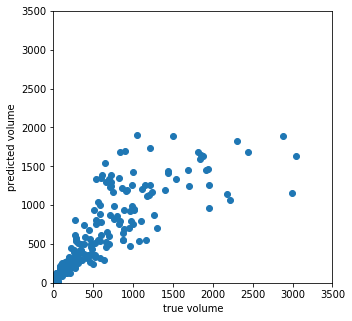

In [758]:
from pygam import GAM


gam=LinearGAM(n_splines=25,spline_order=3)
gam.gridsearch(np.array(X_train), y_train.values)
plt.subplots(figsize=(5,5))
plt.xlim([0,3500])
plt.ylim([0,3500])
plt.scatter(y_train.values, gam.predict(np.array(X_train)))
plt.xlabel('true volume')
plt.ylabel('predicted volume')

plt.plot(y_train, model.predict(XX), 'r--')
plt.plot(XX, model.prediction_intervals(XX,width=0.25), color='b', ls='--    ')


In [759]:
gam.fit(np.array(X_train), y_train.values)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + intercept, 
   tol=0.0001, verbose=False)

Text(0, 0.5, 'predicted volume')

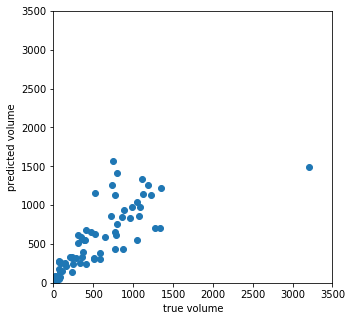

In [760]:
plt.subplots(figsize=(5,5))
plt.xlim([0,3500])
plt.ylim([0,3500])
plt.scatter(y_test.values, gam.predict(np.array(X_test)))
plt.xlabel('true volume')
plt.ylabel('predicted volume')

In [755]:
X1=data.loc[:,{1.0, 2.0, 3.0, 4.0, 5.0, 6.0,"mindist_to_pop","mindist_bikes_sub", "num_bikenodes_in_01", "biketripcount_in_01", "biketripcount_in_005"}]
X1.head(3)
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.25, random_state=42)

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


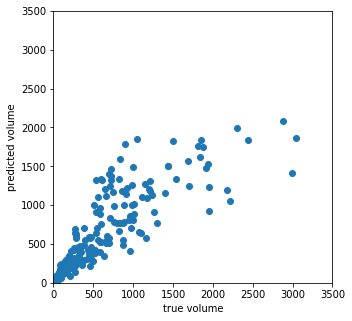

In [756]:

gam1 = LinearGAM()
gam1.gridsearch(np.array(X1_train), y_train.values)
plt.subplots(figsize=(5,5))
plt.xlim([0,3500])
plt.ylim([0,3500])
plt.scatter(y_train.values, gam1.predict(np.array(X1_train)))
plt.xlabel('true volume')
plt.ylabel('predicted volume')
plt.show()



Text(0, 0.5, 'predicted volume')

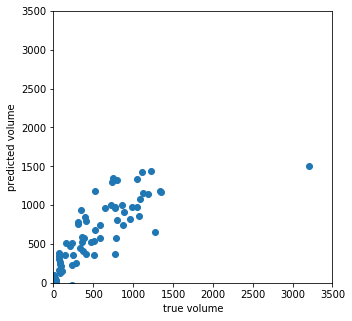

In [754]:
plt.subplots(figsize=(5,5))
plt.xlim([0,3500])
plt.ylim([0,3500])
plt.scatter(y_test.values, gam1.predict(np.array(X1_test)))
plt.xlabel('true volume')
plt.ylabel('predicted volume')

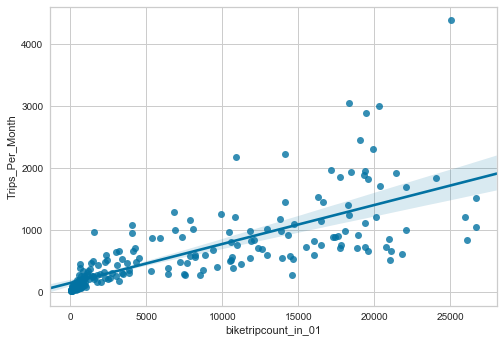

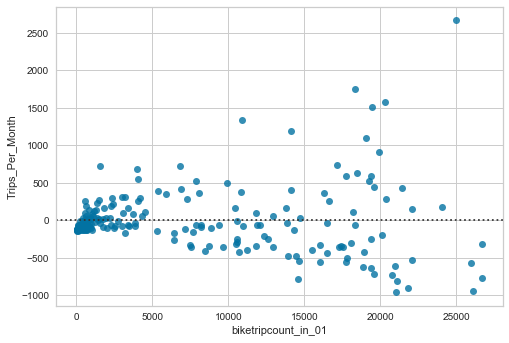

In [782]:
sns.regplot(X_train.biketripcount_in_01, y_train)
plt.show()
sns.residplot(X_train.biketripcount_in_01, y_train)

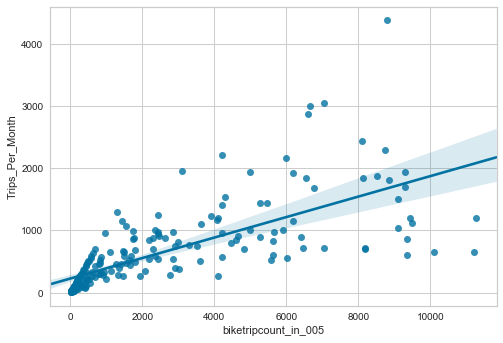

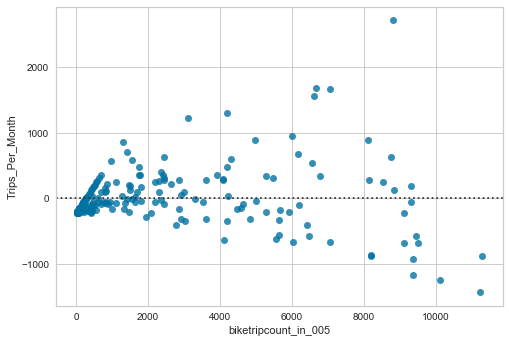

In [781]:
sns.regplot(X_train.biketripcount_in_005, y_train)
plt.show()
sns.residplot(X_train.biketripcount_in_005, y_train)

In [764]:
X_train.head()

,Latitude,biketripcount_in_01,mindist_bikes_sub,biketripcount_in_005,Longitude,num_bikenodes_in_01,mindist_to_pop
115,42.344796,1375.388889,24.782212,791.500000,-71.031614,3,0.000000
137,42.317642,730.679167,5.245796,209.625000,-71.056664,5,33.822182
203,42.306539,916.316667,3.994148,449.108333,-71.107669,4,31.250537
77,42.313917,89.958333,13.342177,89.958333,-71.040250,1,32.063891
18,42.358920,22078.723669,0.065765,6775.586765,-71.057629,18,0.000000


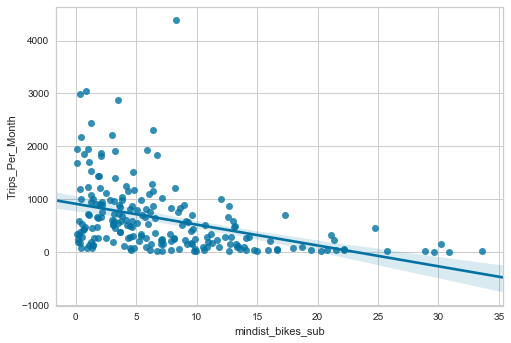

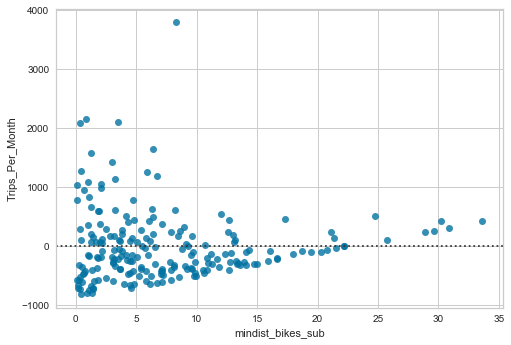

In [779]:
sns.regplot(X_train.mindist_bikes_sub, y_train, order=1)
plt.show()
sns.residplot(X_train.mindist_bikes_sub, y_train, order=1)

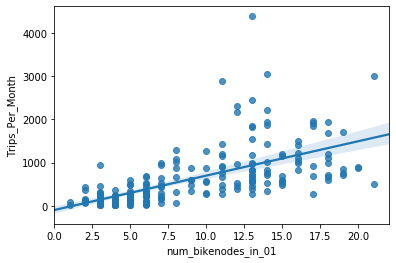

In [766]:
sns.regplot(X_train.num_bikenodes_in_01, y_train)

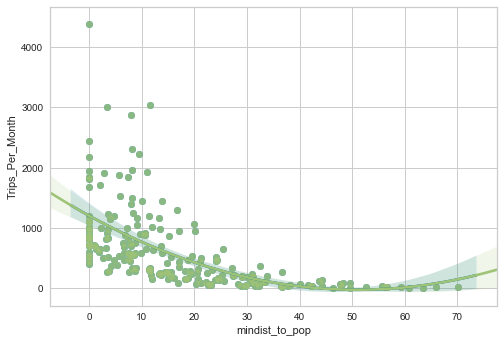

In [775]:
sns.regplot(X_train.mindist_to_pop, y_train, order=2)
sns.regplot(X_train.mindist_to_pop, y_train, order=2)

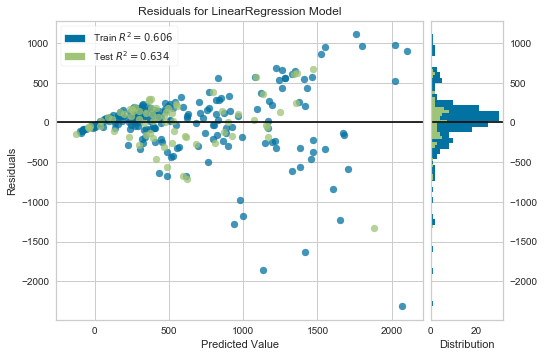

In [773]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(linearmodel)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()